In [ ]:
# dependency parser for python packages
# 12f23eddde <rzhe@pku.edu.cn> - Apr 10 2021

In [40]:
# standard pythonic way of parsing version string
from packaging import version

def parse_version_string(ver: str) -> str:
    res = version.parse(ver)
    # LegacyVersion -> parse failed
    if(isinstance(res, version.LegacyVersion)):
        return ''
    return (str)(res)

parse_version_string('v1.1.1-rc2')

'1.1.1rc2'

In [60]:
import os
REPOS_DIR = 'repos_50/'
if not os.path.exists(REPOS_DIR):
    os.mkdir(REPOS_DIR)
REPOS_DIR = os.path.abspath(REPOS_DIR)

In [81]:
# ref: https://gitpython.readthedocs.io/en/stable/reference.html?highlight=tag#module-git.refs.tag
from git.refs import tag
from git import Repo

# seems to work (only used for testing)
def count_tags(owner: str, repo: str, branch='master'):
    repo = Repo(f'{REPOS_DIR}/{owner}/{repo}/{branch}')
#     repo = Repo(f'{REPOS_DIR}/{owner}/{repo}/')
    tagrefs = tag.TagReference.list_items(repo)
    original_tags = []
    parsed_tags = []
    for tagref in tagrefs:
        tagstr = (str)(tagref).replace('refs/tags/', '')
        # tagged date > commit date (if tag date exists)
#         if tagref.tag:
#             print('tag',tagref.tag.tagged_date, 'commit',tagref.commit.committed_date)
        parsed_tag = parse_version_string(tagstr)
        # append tag only when its name satisfies PEP 440
        # ref: https://packaging.pypa.io/en/latest/version.html
        if parsed_tag:
            original_tags.append(tagstr)
            parsed_tags.append(parsed_tag)
    return len(parsed_tags), len(tagrefs)

In [101]:
import pandas as pd
df_projects_w_requirements = pd.read_csv('data/projects_setup.csv', low_memory=False)
projects_w_requirements = df_projects_w_requirements['Name with Owner'].to_list()
f"{len(projects_w_requirements)} projects with head {projects_w_requirements[0]}"

'28675 projects with head donnemartin/system-design-primer'

In [102]:
from tqdm.auto import tqdm
import git
for index, row in tqdm(df_projects_w_requirements.iterrows(), total=len(df_projects_w_requirements)):
    repo = row['Name with Owner'].split('/')[1]
    owner = row['Name with Owner'].split('/')[0]
    try:
        len1, len2 = count_tags(owner=owner, repo=repo)
        df_projects_w_requirements.at[index, 'parsed_tags'] = len1
        df_projects_w_requirements.at[index, 'original_tags'] = len2
    except Exception:
        pass

  0%|          | 0/28675 [00:00<?, ?it/s]

In [103]:
not_na = df_projects_w_requirements[df_projects_w_requirements['original_tags'].notna()]
not_na

,Name with Owner,setup_parsed,setup_log,setup_exists,requirements_exists,parsed_tags,original_tags
0,donnemartin/system-design-primer,False,NaN,False,False,0.0,0.0
1,vinta/awesome-python,False,NaN,False,True,0.0,0.0
2,TheAlgorithms/Python,False,NaN,False,True,0.0,0.0
3,public-apis/public-apis,False,NaN,False,False,0.0,0.0
4,tensorflow/models,False,NaN,False,False,15.0,16.0
...,...,...,...,...,...,...,...
28670,cybercdh/phishfinder,False,NaN,False,True,0.0,0.0
28671,nlpdata/dream,False,NaN,False,False,0.0,0.0
28672,evilsocket/pwnagotchi-plugins-contrib,False,NaN,False,False,0.0,0.0
28673,BitTheByte/Monitorizer,False,NaN,False,True,0.0,0.0


In [106]:
import numpy as np
res = not_na[not_na['setup_exists'] == True]['parsed_tags'].to_numpy()
np.sum(res)

246998.0

In [107]:
not_na[(not_na['setup_exists'] == True) & (not_na['parsed_tags'] == 0)]

,Name with Owner,setup_parsed,setup_log,setup_exists,requirements_exists,parsed_tags,original_tags
33,faif/python-patterns,False,NaN,True,False,0.0,1.0
35,facebookresearch/Detectron,False,NaN,True,True,0.0,0.0
54,odoo/odoo,True,/home/hrz/miniconda3/lib/python3.8/site-packag...,True,True,0.0,0.0
69,eriklindernoren/ML-From-Scratch,True,NaN,True,True,0.0,0.0
142,jupyter/jupyter,True,NaN,True,False,0.0,0.0
...,...,...,...,...,...,...,...
28626,kaelscion/slither,True,/home/hrz/miniconda3/lib/python3.8/site-packag...,True,False,0.0,0.0
28633,lagmoellertim/freenet-funk-api,True,NaN,True,True,0.0,0.0
28656,alexlee-gk/slac,False,NaN,True,True,0.0,0.0
28665,sagelywizard/pytorch-mdn,False,NaN,True,True,0.0,0.0


zero_val 14502
mean 29.747697031729786
median 11.0
max 15205.0
std 160.17380216599466


{'whiskers': [<matplotlib.lines.Line2D at 0x7f583a28e610>,
 'caps': [<matplotlib.lines.Line2D at 0x7f583a28d100>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f583a28e160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f583a28d310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f583a28d7c0>],
 'means': []}

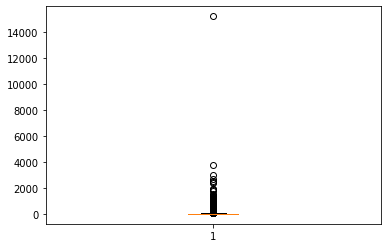

In [92]:
import matplotlib.pyplot as plt
import numpy as np

print('zero_val',len(not_na[not_na['original_tags'] == 0]))
res = not_na[not_na['original_tags'] != 0]['original_tags'].to_numpy()
print('mean',np.mean(res))
print('median',np.median(res))
print('max',np.max(res))
print('std',np.std(res))

plt.boxplot(res)

mean 0.9053742988087347
median 1.0
min 0.0
std 0.2614788973012966


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5864d0e550>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5864cee310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5864d0e3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5864cee430>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5864cee2b0>],
 'means': []}

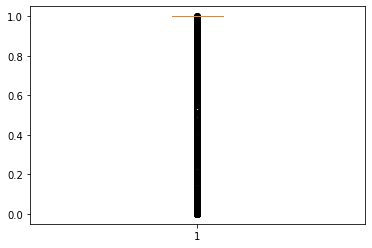

In [96]:
res_parsed = not_na[not_na['original_tags'] != 0]['parsed_tags'].to_numpy()
res2 = res_parsed/res

print('mean',np.mean(res2))
print('median',np.median(res2))
print('min',np.min(res2))
print('std',np.std(res2))
plt.boxplot(res2)